In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import matplotlib.dates as mdates
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional
from keras.optimizers import SGD
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

In [24]:
dataset = pd.read_excel('grocery_price.xlsx', index_col=None)
dataset.head()

,Date,10/03/2021,11/03/2021,12/03/2021,13/03/2021,14/03/2021,15/03/2021,16/03/2021,17/03/2021,18/03/2021,...,18/12/2023,19/12/2023,20/12/2023,21/12/2023,22/12/2023,23/12/2023,24/12/2023,25/12/2023,26/12/2023,27/12/2023
0,Beras,11.5,11.5,11.5,11.5,11.5,11.5,11.61,12.10,11.72,...,14.37,14.37,14.35,14.27,14.33,14.41,14.34,14.33,14.37,14.42
1,Gula Pasir,14.0,14.0,14.0,14.0,14.0,14.0,13.56,13.41,13.60,...,17.77,17.71,17.76,17.80,17.77,17.73,17.72,17.74,17.73,17.73
2,Minyak Goreng,14.5,14.0,14.0,14.0,14.0,14.0,14.26,13.96,14.13,...,17.50,17.40,17.48,17.42,17.14,17.65,17.27,17.47,17.21,17.45


In [25]:
# transform data to from row to column
dataset = dataset.T
dataset.columns = dataset.iloc[0]
dataset = dataset.drop(dataset.index[0])

dataset.head()

Date,Beras,Gula Pasir,Minyak Goreng
10/03/2021,11.5,14.0,14.5
11/03/2021,11.5,14.0,14.0
12/03/2021,11.5,14.0,14.0
13/03/2021,11.5,14.0,14.0
14/03/2021,11.5,14.0,14.0


In [26]:
# add new column to dataset, average of all column 
dataset['Average'] = round(dataset.mean(axis=1),2)

# remove column 2
dataset = dataset.drop(dataset.columns[0:3], axis=1)

dataset.head()

Date,Average
10/03/2021,13.33
11/03/2021,13.17
12/03/2021,13.17
13/03/2021,13.17
14/03/2021,13.17


In [27]:
# split data into training, validation, and test
# 80, 20, 28 hari
train_data = dataset.iloc[0:791] 
validation_data = dataset.iloc[791:995] 
test_data = dataset.iloc[995:1023] 

# change to numpy array
train_data = train_data.values
validation_data = validation_data.values

train_data

array([[13.33],
       [13.17],
       [13.17],
       [13.17],
       [13.17],
       [13.17],
       [13.14],
       [13.16],
       [13.15],
       [13.2 ],
       [13.2 ],
       [13.25],
       [13.17],
       [13.27],
       [13.2 ],
       [13.16],
       [13.24],
       [13.18],
       [13.12],
       [13.22],
       [13.21],
       [13.16],
       [13.24],
       [13.15],
       [13.1 ],
       [13.23],
       [13.19],
       [13.18],
       [13.26],
       [13.18],
       [13.2 ],
       [13.21],
       [13.08],
       [13.26],
       [13.18],
       [13.25],
       [13.24],
       [13.26],
       [13.2 ],
       [13.3 ],
       [13.26],
       [13.18],
       [13.12],
       [13.24],
       [13.35],
       [13.33],
       [13.25],
       [13.21],
       [13.21],
       [13.29],
       [13.23],
       [13.18],
       [13.27],
       [13.24],
       [13.2 ],
       [13.26],
       [13.25],
       [13.21],
       [13.31],
       [13.19],
       [13.34],
       [13.26],
       [

In [28]:
# normalize using minmaxscaler
sc = MinMaxScaler(feature_range=(0,1))
train_data_scaled = sc.fit_transform(train_data)
validation_data_scaled = sc.fit_transform(validation_data)
train_data_scaled

array([[0.07331378],
       [0.02639296],
       [0.02639296],
       [0.02639296],
       [0.02639296],
       [0.02639296],
       [0.01759531],
       [0.02346041],
       [0.02052786],
       [0.03519062],
       [0.03519062],
       [0.04985337],
       [0.02639296],
       [0.05571848],
       [0.03519062],
       [0.02346041],
       [0.04692082],
       [0.02932551],
       [0.01173021],
       [0.04105572],
       [0.03812317],
       [0.02346041],
       [0.04692082],
       [0.02052786],
       [0.0058651 ],
       [0.04398827],
       [0.03225806],
       [0.02932551],
       [0.05278592],
       [0.02932551],
       [0.03519062],
       [0.03812317],
       [0.        ],
       [0.05278592],
       [0.02932551],
       [0.04985337],
       [0.04692082],
       [0.05278592],
       [0.03519062],
       [0.06451613],
       [0.05278592],
       [0.02932551],
       [0.01173021],
       [0.04692082],
       [0.07917889],
       [0.07331378],
       [0.04985337],
       [0.038

In [29]:
# create input sequences
def create_sequences(data, seq_length=60):
    x=[]
    y=[]
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i,0])
        y.append(data[i,0])
    return np.array(x), np.array(y)

x_train, y_train = create_sequences(train_data_scaled)
x_val, y_val = create_sequences(validation_data_scaled)


In [30]:
# Create the SVR model
model = SVR(kernel='rbf', C=1e3, gamma=0.1)

In [31]:
#  Compiling the LSTM Model
model.fit(x_train, y_train)

SVR(C=1000.0, gamma=0.1)

In [32]:
svr_confidence = model.score(x_val, y_val)
print("SVR confidence: ", svr_confidence)

#export model
# import joblib
# joblib.dump(model, 'SVR.pkl')

import pickle
pickle.dump(model, open("SVR2.pkl", "wb"))


SVR confidence:  0.9224706061337462


In [33]:
x_pred = x_val.reshape(-1,60)
y_pred = model.predict(x_pred)

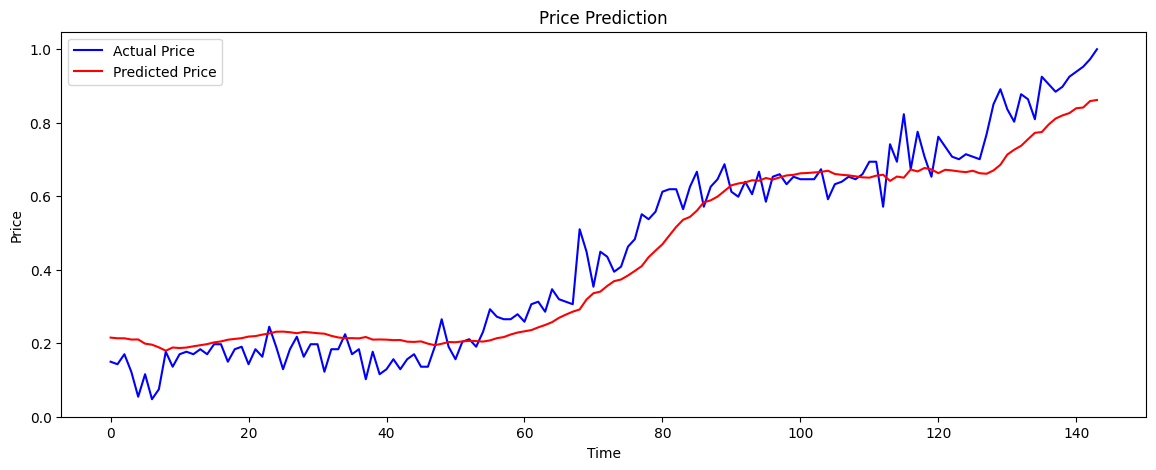

In [34]:
# plot the result of prediction
plt.figure(figsize=(14,5))
plt.plot(y_val, color='blue', label='Actual Price')
plt.plot(y_pred, color='red', label='Predicted Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
